Data Preprocessing

In [ ]:
import torch

if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    print(f"Number of GPUs available: {n_gpu}")
    for i in range(n_gpu):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU is available.")

In [ ]:
import os

# Define the path to the dataset and the partitions
dataset_path = 'Data'
partition = 'valid'
images_folder = 'images'
labels_folder = 'labels'

# Construct the path to the images folder within the train partition
images_path = os.path.join(dataset_path, partition, images_folder)
labels_folder_path = os.path.join(dataset_path, partition, labels_folder)

# Count the number of files in the images folder
num_files = len([name for name in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, name))])
num_text_files = len([name for name in os.listdir(labels_folder_path) if os.path.isfile(os.path.join(labels_folder_path, name))])

print(f"Number of files in folder 'images' in 'train': {num_files}")
print(f"Number of files in folder 'labels' in 'train': {num_text_files}")


In [7]:
|import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
#import matplotlib.patches as patches

def parse_annotation(annotation_line):
    parts = annotation_line.strip().split()
    class_id = int(parts[0])  # The class_id is the first element
    vertices = np.array(parts[1:], dtype=np.float32)  # The rest are the vertices
    return class_id, vertices.reshape((-1, 2))  # Reshape to Nx2 where N is the number of vertices

def draw_polygon_on_mask(mask, corners, image_shape):
    scaled_corners = corners * np.array([image_shape[1], image_shape[0]], dtype=np.float32)  # scale x and y
    scaled_corners = np.around(scaled_corners).astype(np.int32)  # round and convert to int


    corners_int = scaled_corners.reshape((-1, 1, 2))
    cv2.fillPoly(mask, [corners_int], color=(255))  # Ensure fillPoly is used, not polylines


def create_mask_from_annotations(annotation_path, image_shape):
    mask = np.zeros((image_shape[0], image_shape[1]), dtype=np.uint8)  # Create a black mask
    with open(annotation_path, 'r') as file:
        for line in file:
            class_id, vertices = parse_annotation(line)
            draw_polygon_on_mask(mask, vertices, image_shape)  # Draw each polygon on the mask
    return mask

def preprocess_image(image_path, annotation_path, target_size):
    # Open and resize image
    image = Image.open(image_path).resize(target_size)
    mask = create_mask_from_annotations(annotation_path, target_size)  # Note the reversal of width and height for the mask
    return np.array(image), mask

def process_directory(data_dir, annotation_dir, target_size):
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            # Paths for the image and its corresponding annotation file
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))

            # Check if the annotation file exists
            if not os.path.isfile(annotation_path):
                print(f"Annotation file does not exist for {image_path}")
                continue  # Skip this image

            # Preprocess the image and create the mask from the annotation
            image, mask = preprocess_image(image_path, annotation_path, target_size)

            # Visualization for debugging
            corners = []  # Store the vertices for debugging visualization
            with open(annotation_path, 'r') as file:
                for line in file:
                    class_id, vertices = parse_annotation(line)
                    corners.append(vertices)

            #debug_visualization(image, mask, corners, title=os.path.basename(image_path))

            # Save the processed image and mask as .npy files
            image_npy_path = os.path.join(data_dir, img_filename.replace('.jpg', '_img.npy'))
            mask_npy_path = os.path.join(data_dir, img_filename.replace('.jpg', '_mask.npy'))

            np.save(image_npy_path, image)
            np.save(mask_npy_path, mask)

def save_as_npy(data_dir, annotation_dir, target_size=(224, 224)):
    processed_data = []
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))
            image, mask = preprocess_image(image_path, annotation_path, target_size)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_img.npy')), image)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_mask.npy')), mask)
            processed_data.append((image, mask))
    print(f"Processed and saved {len(processed_data)} image-mask pairs in .npy format.")

# Example usage
# dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
dataset_base = r'Data'
partitions = ['train', 'valid', 'test']
target_size = (512,512)  # Change as required by your model

# Process images and annotations and save them as .npy files
# Process images and annotations
for part in partitions:
    images_dir = os.path.join(dataset_base, part, 'images')
    annotations_dir = os.path.join(dataset_base, part, 'labels')
    process_directory(images_dir, annotations_dir, target_size)
    print(f"Finished processing {part} set")

# Visualization (example for one image from the 'train' set)
train_images_dir = os.path.join(dataset_base, 'train', 'images')
train_image_files = [f for f in os.listdir(train_images_dir) if f.endswith('_img.npy')]

# Load one image and its corresponding mask
image = np.load(os.path.join(train_images_dir, train_image_files[0]))
mask = np.load(os.path.join(train_images_dir, train_image_files[0].replace('_img.npy', '_mask.npy')))

# # Visualize the image and the mask
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.title('Processed Image')
# plt.axis('off')
# 
# plt.subplot(1, 2, 2)
# plt.imshow(mask, cmap='gray')
# plt.title('Processed Mask')
# plt.axis('off')
# 
# plt.show()

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


OSError: 786432 requested and 3968 written


Semantics CNN

In [14]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import time
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the CNN architecture for segmentation
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        # Encoder layers
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Decoder layers
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # Final output layer
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        # Encoder pathway
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        # Decoder pathway
        x = self.dec4(x4)
        x = self.dec3(x + x3)  # Adding skip connection
        x = self.dec2(x + x2)  # Adding skip connection
        x = self.dec1(x + x1)  # Adding skip connection

        # Final output
        return self.final(x)

class PKLotDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('_img.npy')]
        self.transform = transform
        print(f"Found {len(self.image_files)} images in directory {data_dir}")  # Debugging output

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.image_files[idx])
        mask_file = image_file.replace('_img.npy', '_mask.npy')

        image = np.load(image_file)
        mask = np.load(mask_file)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
dataset_base = r'Data'
partitions = ['train', 'valid', 'test']
target_size = (224, 224)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred.sigmoid()
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        intersection = (y_pred_flat * y_true_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (y_pred_flat.sum() + y_true_flat.sum() + self.smooth)
        return 1 - dice_coeff

# Create datasets and dataloaders for train, validation, and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))  # Resizing the image if needed
])

train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), transform=transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), transform=transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationModel().to(device)
print (model)
summary(model, input_size=(3, 224, 224))  # Adjust input size as necessary
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

start_time = time.time()
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    all_preds = []
    all_true = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = (outputs > 0.5).float()
            total_loss += loss.item() * images.size(0)
            total_correct += preds.eq(masks).sum().item()
            total_pixels += masks.numel()
            all_preds.append(preds.view(-1).cpu().numpy())
            all_true.append(masks.view(-1).cpu().numpy())

    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    cm = confusion_matrix(all_true, all_preds)
    return average_loss, accuracy, cm

def plot_confusion_matrix(cm, classes=['Empty', 'Occupied'], title='Confusion Matrix - Parking Spots'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
# Training loop
for epoch in range(100):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    train_loss, train_accuracy, _ = evaluate(model, train_loader, criterion, device)
    val_loss, val_accuracy, val_cm = evaluate(model, valid_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch+1}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Plot the confusion matrix for the current epoch
    plot_confusion_matrix(val_cm, classes=['Empty', 'Occupied'], title=f'Validation Confusion Matrix - Parking Spots, Epoch {epoch+1}')

# Final reporting of test metrics
test_loss, test_accuracy, test_cm = evaluate(model, test_loader, criterion, device)
print("Test Metrics:")
print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Plot final confusion matrix for test data
plot_confusion_matrix(test_cm, classes=['Empty', 'Occupied'], title='Test Confusion Matrix - Parking Spots')


# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# # Save the trained model
# torch.save(model, 'CNN_model.pth')
# 
# # Load the trained model for testing
# loaded_model = torch.load('CNN_model.pth')
# loaded_model.eval()

def check_masks(data_loader):
    for images, masks in data_loader:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(images[0].permute(1, 2, 0))  # Adjust permute for your specific case
        axs[0].set_title('Original Image')
        axs[1].imshow(masks[0].squeeze(), cmap='gray')
        axs[1].set_title('Mask')
        plt.show()
        break  # Just show one batch for checking

check_masks(train_loader)  # Check first batch of the training loader
 
# Visualize the model predictions with confidence scores
def visualize_with_confidence(model, loader, device, num_examples=5, threshold=0.5):
    model.eval()
    indices = torch.randperm(len(loader.dataset))[:num_examples]  # Randomly select indices
    subset = torch.utils.data.Subset(loader.dataset, indices)     # Create a subset based on these indices
    sub_loader = torch.utils.data.DataLoader(subset, batch_size=1)  # Load the subset

    with torch.no_grad():
        for images, masks in sub_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            preds = (sigmoid_outputs > threshold).float()

            images_np = images.cpu().numpy()
            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()
            sigmoid_outputs_np = sigmoid_outputs.cpu().numpy()

            fig, ax = plt.subplots(1, 4, figsize=(20, 5))
            ax[0].imshow(images_np[0].transpose(1, 2, 0))
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            ax[1].imshow(masks_np[0].squeeze(), cmap='gray')
            ax[1].set_title('True Mask')
            ax[1].axis('off')

            ax[2].imshow(preds_np[0].squeeze(), cmap='gray')
            ax[2].set_title('Predicted Mask')
            ax[2].axis('off')

            overlay_image = images_np[0].transpose(1, 2, 0).copy()
            for y in range(0, preds_np[0].shape[1], 32):  # Adjust grid size if needed
                for x in range(0, preds_np[0].shape[2], 32):
                    conf_score = np.mean(sigmoid_outputs_np[0][:, y:y+32, x:x+32])
                    status = "Occupied" if conf_score > threshold else "Empty"
                    rect_color = 'red' if status == "Occupied" else 'green'
                    rect = patches.Rectangle((x, y), 32, 32, linewidth=2, edgecolor=rect_color, facecolor='none')
                    ax[3].add_patch(rect)
                    ax[3].text(x + 1, y + 16, f'{status}\n{conf_score:.2f}', color='white', fontsize=10, ha='left', va='center')
            ax[3].imshow(overlay_image)
            ax[3].set_title('Overlay Image with Confidence')
            ax[3].axis('off')

            plt.show()

# Example call with updated parameters
visualize_with_confidence(model, test_loader, device, num_examples=5, threshold=0.5)

end_time = time.time()
inference_time = end_time - start_time
print(f"Total Time taken for inference: {inference_time:.4f} seconds")

cuda
Found 8471 images in directory Data/train/images
Found 2483 images in directory Data/valid/images
Found 1240 images in directory Data/test/images
SegmentationModel(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, 

ValueError: cannot reshape array of size 3968 into shape (512,512,3)

In [56]:
import os
import math
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import timm
from PIL import Image
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class CustomVisionTransformer(nn.Module):
    def __init__(self, base_model_name='vit_base_patch16_224', pretrained=True):
        super(CustomVisionTransformer, self).__init__()
        self.base_vit = timm.create_model(base_model_name, pretrained=pretrained, num_classes=0)
        self.base_vit.head = nn.Identity()  # Bypass the classification head

    def forward(self, x):
        # Directly accessing the transformer blocks might require specific changes depending on the timm version
        x = self.base_vit.forward_features(x)
        return x

class VisionTransformerForSegmentation(nn.Module):
    def __init__(self, img_size, num_classes, patch_size=16):
        super(VisionTransformerForSegmentation, self).__init__()
        self.vit = CustomVisionTransformer()
        self.patch_size = patch_size
        self.num_patches_side = img_size // patch_size  # This should be 14 for 224/16
        self.decoder = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        self.img_size = img_size

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.vit(x)  # (B, num_patches+1, embedding_dim)

        # Ensure to skip the CLS token if present
        if x.shape[1] == (self.num_patches_side ** 2 + 1):
            x = x[:, 1:, :]  # Skip the CLS token

        # Re-calculate the expected number of patches without the CLS token
        expected_num_patches = self.num_patches_side ** 2
        if x.shape[1] != expected_num_patches:
            raise ValueError(f"Expected number of patches {expected_num_patches}, but got {x.shape[1]}")

        x = x.permute(0, 2, 1)  # (B, embedding_dim, num_patches)
        x = x.view(B, -1, self.num_patches_side, self.num_patches_side)  # (B, embedding_dim, num_patches_side, num_patches_side)
        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        x = self.decoder(x)
        return x

# Example usage
model = VisionTransformerForSegmentation(img_size=224, num_classes=2).to(device)
    

class PKLotDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('_img.npy')]
        self.transform = transform
        print(f"Found {len(self.image_files)} images in directory {data_dir}")

    def __len__(self):
        return len(self.image_files)  # This should return the number of items in the dataset

    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.image_files[idx])
        mask_file = image_file.replace('_img.npy', '_mask.npy')

        image = np.load(image_file)
        mask = np.load(mask_file)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = outputs > 0.5
            total_loss += loss.item() * images.size(0)
            total_correct += preds.eq(masks).sum().item()
            total_pixels += masks.numel()

    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    return average_loss, accuracy

# dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
dataset_base = r'Data'
partitions = ['train', 'valid', 'test']
target_size = (512, 512)


# Create datasets and dataloaders for train, validation, and test sets
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), transform=transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), transform=transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss function, and optimizer
model = VisionTransformerForSegmentation(img_size=512, num_classes=2).to(device)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize lists to store accuracies for each batch
accuracies = []
train_losses = []
valid_losses = []
valid_accuracies = []
train_accuracies = []
start_time = time.time()
# Training loop
for epoch in range(5):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == masks).float().sum().item()
        train_total += masks.numel()
    
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(train_correct / train_total)
    
    # Validation step
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            valid_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            valid_correct += (preds == masks).float().sum().item()
            valid_total += masks.numel()
    
    valid_losses.append(valid_loss / len(valid_loader.dataset))
    valid_accuracies.append(valid_correct / valid_total)

    print(f'Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {valid_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, Val Acc = {valid_accuracies[-1]:.4f}')

# Plotting training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training vs validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'car_segmentation_model1.pth')

# Load the trained model for testing
model.load_state_dict(torch.load('car_segmentation_model1.pth'))
model.to(device)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    all_preds = []
    all_true = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            total_loss += loss.item() * images.size(0)
            total_correct += (preds == masks).float().sum().item()
            total_pixels += masks.numel()

            all_preds.append(preds.view(-1).cpu().numpy())
            all_true.append(masks.view(-1).cpu().numpy())

    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='binary')
    cm = confusion_matrix(all_true, all_preds)

    return average_loss, accuracy, precision, recall, f1, cm

# Calculate test metrics and plot confusion matrix
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(test_cm, classes=['Background', 'Object'], title='Test Confusion Matrix')

def visualize_with_confidence(model, loader, device, num_examples=1, threshold=0.5):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            if i >= num_examples:  # Only visualize a certain number of examples
                break

            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            preds = (sigmoid_outputs > threshold).float()

            images_np = images.cpu().numpy()
            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()
            sigmoid_outputs_np = sigmoid_outputs.cpu().numpy()

            for idx in range(len(images)):
                fig, ax = plt.subplots(1, 4, figsize=(20, 5))

                ax[0].imshow(images_np[idx].transpose(1, 2, 0))
                ax[0].set_title('Original Image')
                ax[0].axis('off')

                ax[1].imshow(masks_np[idx].squeeze(), cmap='gray')
                ax[1].set_title('True Mask')
                ax[1].axis('off')

                ax[2].imshow(preds_np[idx].squeeze(), cmap='gray')
                ax[2].set_title('Predicted Mask')
                ax[2].axis('off')

                overlay_image = images_np[idx].transpose(1, 2, 0).copy()
                step_size_height = overlay_image.shape[0] // 4  # where `number_of_rows` is the number of parking rows in the image
                step_size_width = overlay_image.shape[1] // 22  # where `number_of_slots_per_row` is the number of parking slots per row in the image

                for y in range(0, preds_np[idx].shape[1], step_size_height):  
                    for x in range(0, preds_np[idx].shape[2], step_size_width):  
                        conf_score = np.mean(sigmoid_outputs_np[idx][:, y:y+step_size_height, x:x+step_size_width])
                        status = "Occupied" if conf_score > threshold else "Empty"
                        color = 'r' if status == "Occupied" else 'g'
                        rect = patches.Rectangle((x, y), step_size_width, step_size_height, linewidth=1, edgecolor=color, facecolor='none')
                        ax[3].add_patch(rect)
                        # To prevent text overlay, consider only labeling every other slot or a selection of slots
                        if (x // step_size_width) % 2 == 0:  # Example condition to reduce label frequency
                            ax[3].text(x+3, y+step_size_height//2, f'{status}\n{conf_score:.2f}', color=color, fontsize=8, ha='center')
                ax[3].imshow(overlay_image)
                ax[3].set_title('Overlay Image with Confidence')
                ax[3].axis('off')
                plt.show()

# Call the function with train or test loader
visualize_with_confidence(model, test_loader, device, num_examples=1, threshold=0.5)

end_time = time.time()
inference_time = end_time - start_time
print(f"Total Time taken for inference: {inference_time:.4f} seconds")

cuda
Found 8471 images in directory Data/train/images
Found 2483 images in directory Data/valid/images
Found 1242 images in directory Data/test/images


ValueError: Expected number of patches 1024, but got 197

In [ ]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import models, transforms
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred.sigmoid()
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        intersection = (y_pred_flat * y_true_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (y_pred_flat.sum() + y_true_flat.sum() + self.smooth)
        return 1 - dice_coeff

class ResNetSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(ResNetSegmentation, self).__init__()

        # Load a pre-trained ResNet model with fewer layers
        backbone = models.resnet18(pretrained=True)  # Using ResNet-18 for simplicity, modify if ResNet-10 is available

        # Modify the backbone for fewer layers if custom smaller version like ResNet-10 needed,
        # this example directly takes ResNet-18 and modifies it
        
        # Remove the last layer (fully connected layer) and adaptive pooling
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        # Adding upsampling layers
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # ResNet-18 features
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.upsample(x)
        return x


class PKLotDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('_img.npy')]
        self.transform = transform
        print(f"Found {len(self.image_files)} images in directory {data_dir}")  # Debugging output

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.image_files[idx])
        mask_file = image_file.replace('_img.npy', '_mask.npy')

        image = np.load(image_file)
        mask = np.load(mask_file)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred.sigmoid()
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        intersection = (y_pred_flat * y_true_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (y_pred_flat.sum() + y_true_flat.sum() + self.smooth)
        return 1 - dice_coeff

# Define transforms, dataset and dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))  # Resizing the image if needed
])
dataset_base = 'Data'
train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), transform=transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), transform=transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup model, loss, and optimizer
model = ResNetSegmentation(num_classes=1).to(device)  # Assuming binary segmentation
print(model)
summary(model, (3, 512, 512))
print (model)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Lists to store metrics for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

# Evaluation function including precision, recall, F1-score, and confusion matrix
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    all_preds, all_true = [], []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = (outputs > 0.5).float()
            total_loss += loss.item() * images.size(0)
            total_correct += preds.eq(masks).sum().item()
            total_pixels += masks.numel()
            all_preds.append(preds.view(-1).cpu().numpy())
            all_true.append(masks.view(-1).cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='binary')
    cm = confusion_matrix(all_true, all_preds)
    return average_loss, accuracy, precision, recall, f1, cm  # Include confusion matrix in the return statement

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_pixels = 0
    train_preds, train_true = [], []

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).float()
        total_train_correct += preds.eq(masks).sum().item()
        total_train_pixels += masks.numel()
        train_preds.append(preds.view(-1).cpu().numpy())
        train_true.append(masks.view(-1).cpu().numpy())

    train_loss = total_train_loss / len(train_loader.dataset)
    train_accuracy = total_train_correct / total_train_pixels
    train_preds = np.concatenate(train_preds)
    train_true = np.concatenate(train_true)
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_true, train_preds, average='binary')

    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate(model, valid_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Accuracy {train_accuracy:.4f}, Precision {train_precision:.4f}, Recall {train_recall:.4f}, F1 {train_f1:.4f}")
    print(f"Epoch {epoch+1}: Validation Loss {val_loss:.4f}, Accuracy {val_accuracy:.4f}, Precision {val_precision:.4f}, Recall {val_recall:.4f}, F1 {val_f1:.4f}")
    print("Validation Confusion Matrix:")
    print(val_cm)

print ("Final Training Metrcis:")
print (f"Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f},Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

print("Final Validation Metrics:")
print(f"Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}", "Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")
 
# Test Evaluation
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate(model, test_loader, criterion, device)
print(f"Test Evaluation - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")
print("Test Confusion Matrix:")
print(test_cm)

# Plotting the confusion matrix for the test phase
plot_confusion_matrix(test_cm, title='Test Confusion Matrix')

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example of how to call it
plot_confusion_matrix(test_cm, title='Test Confusion Matrix')
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize predictions with confidence scores
def visualize_with_confidence(model, loader, device, num_examples=5, threshold=0.5):
    model.eval()
    indices = torch.randperm(len(loader.dataset))[:num_examples]  # Randomly select indices
    subset = torch.utils.data.Subset(loader.dataset, indices)     # Create a subset based on these indices
    sub_loader = torch.utils.data.DataLoader(subset, batch_size=1)  # Load the subset

    with torch.no_grad():
        for images, masks in sub_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            preds = (sigmoid_outputs > threshold).float()

            images_np = images.cpu().numpy()
            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()
            sigmoid_outputs_np = sigmoid_outputs.cpu().numpy()

            fig, ax = plt.subplots(1, 4, figsize=(20, 5))
            ax[0].imshow(images_np[0].transpose(1, 2, 0))
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            ax[1].imshow(masks_np[0].squeeze(), cmap='gray')
            ax[1].set_title('True Mask')
            ax[1].axis('off')

            ax[2].imshow(preds_np[0].squeeze(), cmap='gray')
            ax[2].set_title('Predicted Mask')
            ax[2].axis('off')

            overlay_image = images_np[0].transpose(1, 2, 0).copy()
            for y in range(0, preds_np[0].shape[1], 32):  # Adjust grid size if needed
                for x in range(0, preds_np[0].shape[2], 32):
                    conf_score = np.mean(sigmoid_outputs_np[0][:, y:y+32, x:x+32])
                    status = "Occupied" if conf_score > threshold else "Empty"
                    rect_color = 'red' if status == "Occupied" else 'green'
                    rect = patches.Rectangle((x, y), 32, 32, linewidth=2, edgecolor=rect_color, facecolor='none')
                    ax[3].add_patch(rect)
                    ax[3].text(x + 1, y + 16, f'{status}\n{conf_score:.2f}', color='white', fontsize=10, ha='left', va='center')
            ax[3].imshow(overlay_image)
            ax[3].set_title('Overlay Image with Confidence')
            ax[3].axis('off')

            plt.show()

# Example call with updated parameters
visualize_with_confidence(model, test_loader, device, num_examples=5, threshold=0.5)

# Save the model
torch.save(model.state_dict(), 'unet_model2.pth')

Using device: cuda
Found 8471 images in directory Data/train/images
Found 2483 images in directory Data/valid/images
Found 1242 images in directory Data/test/images
UNet(
  (encoder): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

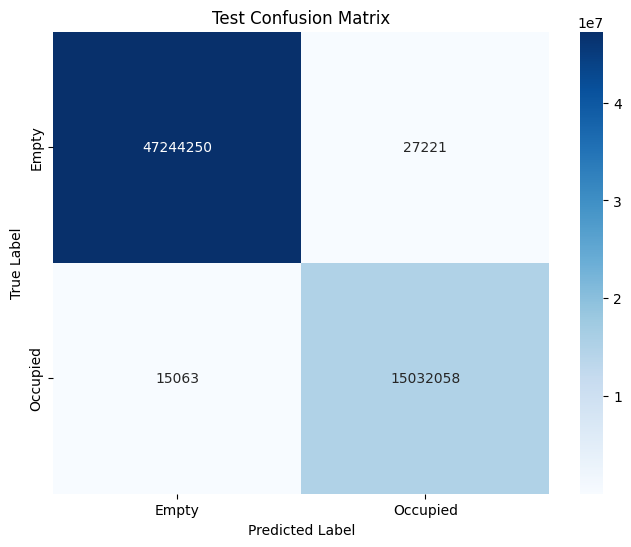

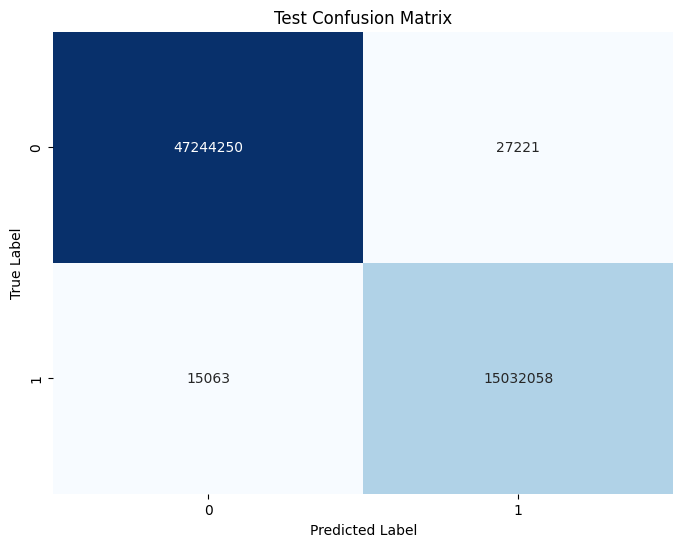

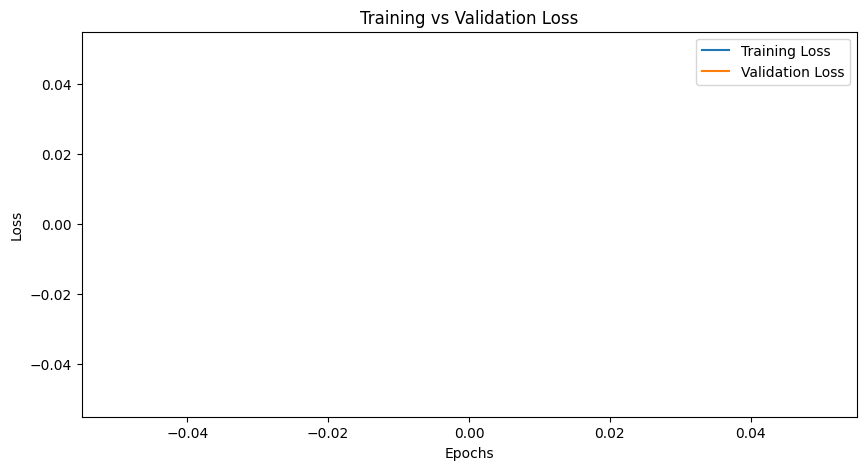

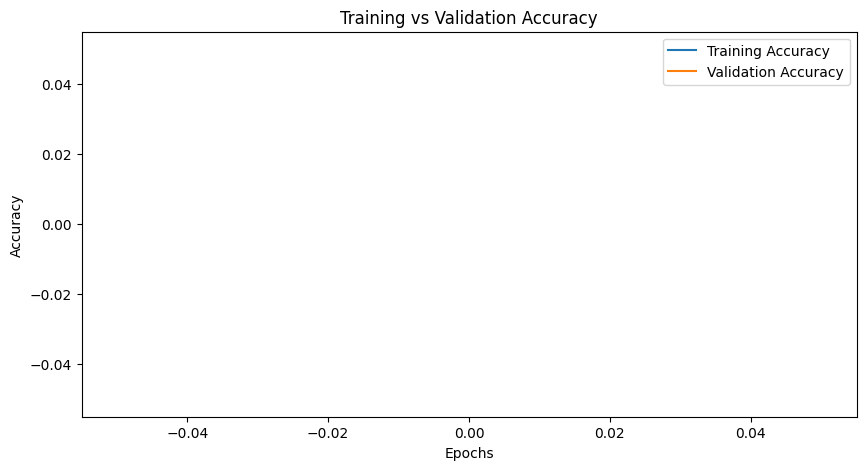

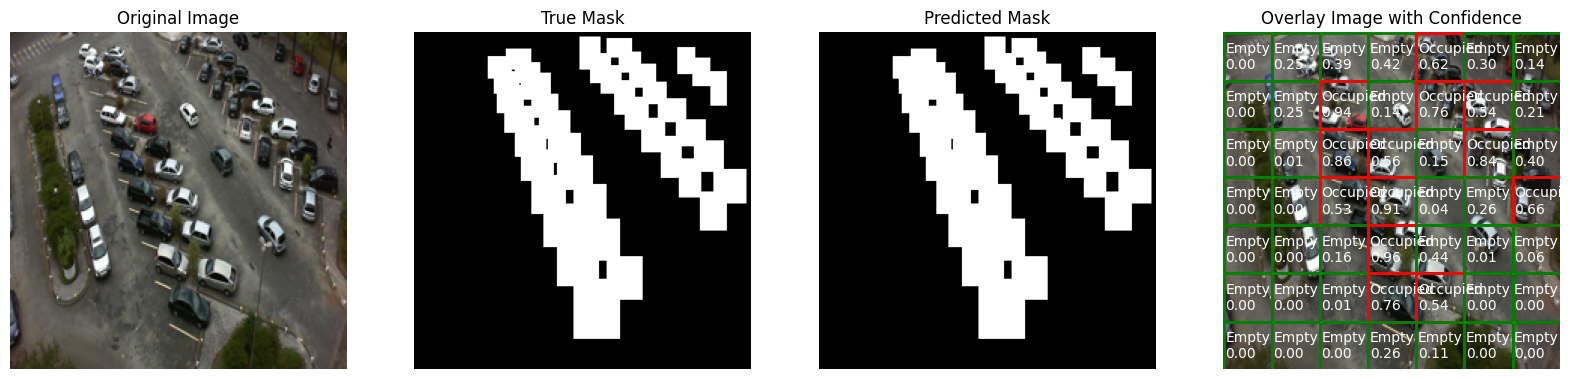

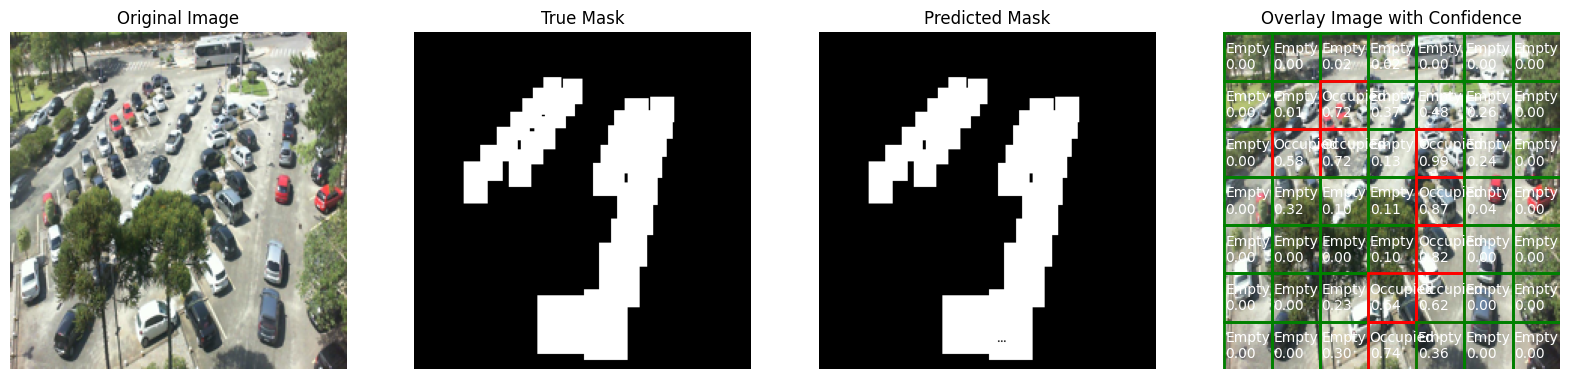

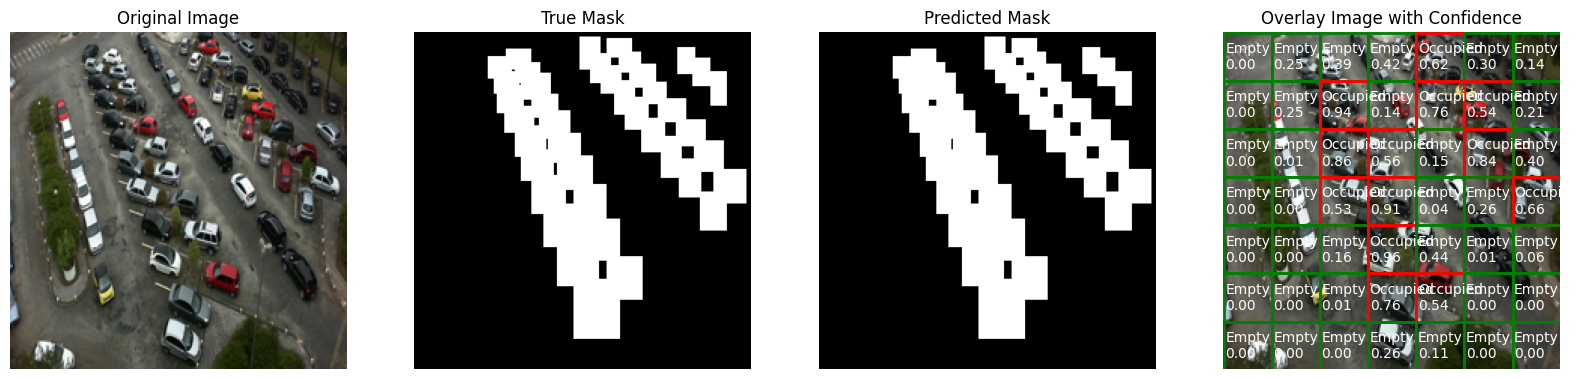

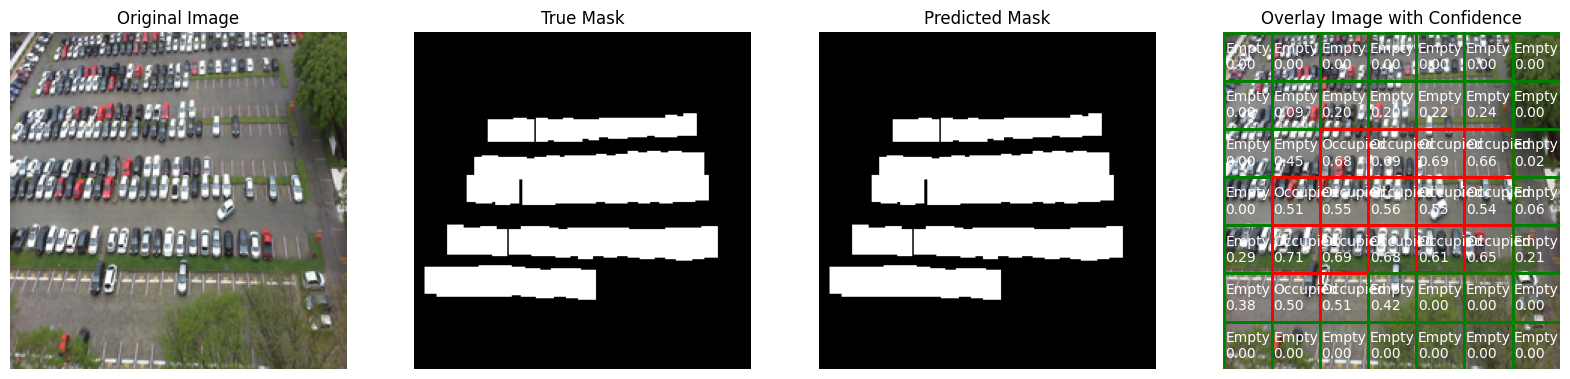

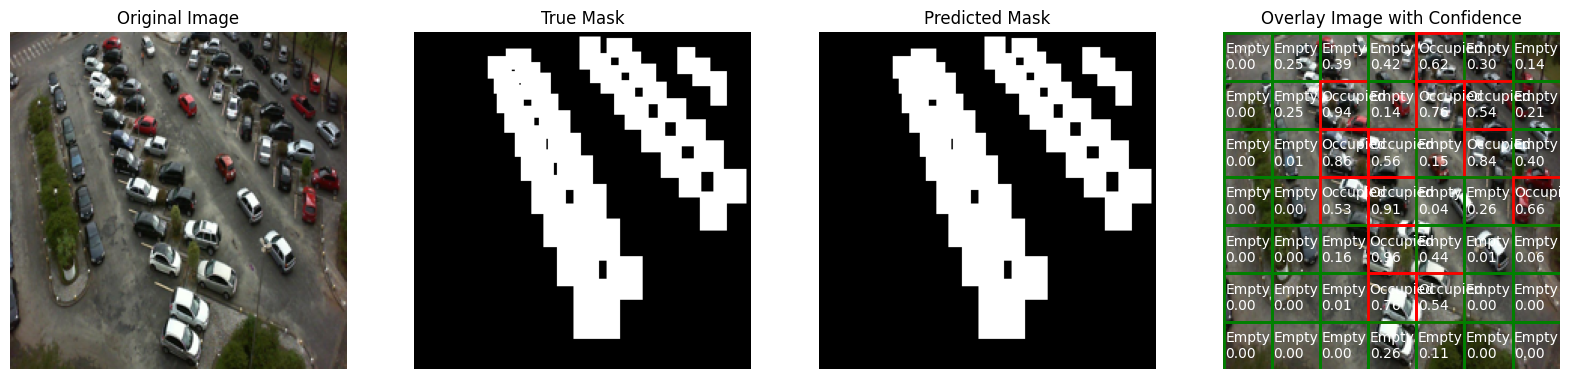

In [66]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from PIL import Image
import torch.nn.functional as F
import matplotlib.patches as patches

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dice Loss Definition
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred.sigmoid()
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        intersection = (y_pred_flat * y_true_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (y_pred_flat.sum() + y_true_flat.sum() + self.smooth)
        return 1 - dice_coeff

# Double Convolution Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# UNet Architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder part
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder part
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(DoubleConv(feature * 2, feature))

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                skip_connection = skip_connection[:, :, :x.shape[2], :x.shape[3]]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](concat_skip)

        return self.final_conv(x)

# Dataset handling
class PKLotDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('_img.npy')]
        self.transform = transform
        print(f"Found {len(self.image_files)} images in directory {data_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.image_files[idx])
        mask_file = image_file.replace('_img.npy', '_mask.npy')

        image = np.load(image_file)
        mask = np.load(mask_file)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transforms, dataset and dataloaders
transform = transforms.Compose([transforms.ToTensor()])
dataset_base = 'Data'
train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), transform=transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), transform=transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup model, loss, and optimizer
model = UNet(in_channels=3, out_channels=1).to(device)
print (model)
summary(model, (3, 512, 512))
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Lists to store metrics for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

# Evaluation function including precision, recall, F1-score, and confusion matrix
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    all_preds, all_true = [], []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = (outputs > 0.5).float()
            total_loss += loss.item() * images.size(0)
            total_correct += preds.eq(masks).sum().item()
            total_pixels += masks.numel()
            all_preds.append(preds.view(-1).cpu().numpy())
            all_true.append(masks.view(-1).cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='binary')
    cm = confusion_matrix(all_true, all_preds)
    return average_loss, accuracy, precision, recall, f1, cm  # Include confusion matrix in the return statement

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_pixels = 0
    train_preds, train_true = [], []

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).float()
        total_train_correct += preds.eq(masks).sum().item()
        total_train_pixels += masks.numel()
        train_preds.append(preds.view(-1).cpu().numpy())
        train_true.append(masks.view(-1).cpu().numpy())

    train_loss = total_train_loss / len(train_loader.dataset)
    train_accuracy = total_train_correct / total_train_pixels
    train_preds = np.concatenate(train_preds)
    train_true = np.concatenate(train_true)
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_true, train_preds, average='binary')

    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate(model, valid_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Accuracy {train_accuracy:.4f}, Precision {train_precision:.4f}, Recall {train_recall:.4f}, F1 {train_f1:.4f}")
    print(f"Epoch {epoch+1}: Validation Loss {val_loss:.4f}, Accuracy {val_accuracy:.4f}, Precision {val_precision:.4f}, Recall {val_recall:.4f}, F1 {val_f1:.4f}")
    print("Validation Confusion Matrix:")
    print(val_cm)

print ("Final Training Metrcis:")
print (f"Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f},Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

print("Final Validation Metrics:")
print(f"Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}", "Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")
 
# Test Evaluation
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate(model, test_loader, criterion, device)
print(f"Test Evaluation - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")
print("Test Confusion Matrix:")
print(test_cm)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example of how to call it
plot_confusion_matrix(test_cm, title='Test Confusion Matrix')
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize predictions with confidence scores
def visualize_with_confidence(model, loader, device, num_examples=5, threshold=0.5):
    model.eval()
    indices = torch.randperm(len(loader.dataset))[:num_examples]  # Randomly select indices
    subset = torch.utils.data.Subset(loader.dataset, indices)     # Create a subset based on these indices
    sub_loader = torch.utils.data.DataLoader(subset, batch_size=1)  # Load the subset

    with torch.no_grad():
        for images, masks in sub_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            preds = (sigmoid_outputs > threshold).float()

            images_np = images.cpu().numpy()
            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()
            sigmoid_outputs_np = sigmoid_outputs.cpu().numpy()

            fig, ax = plt.subplots(1, 4, figsize=(20, 5))
            ax[0].imshow(images_np[0].transpose(1, 2, 0))
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            ax[1].imshow(masks_np[0].squeeze(), cmap='gray')
            ax[1].set_title('True Mask')
            ax[1].axis('off')

            ax[2].imshow(preds_np[0].squeeze(), cmap='gray')
            ax[2].set_title('Predicted Mask')
            ax[2].axis('off')

            overlay_image = images_np[0].transpose(1, 2, 0).copy()
            for y in range(0, preds_np[0].shape[1], 32):  # Adjust grid size if needed
                for x in range(0, preds_np[0].shape[2], 32):
                    conf_score = np.mean(sigmoid_outputs_np[0][:, y:y+32, x:x+32])
                    status = "Occupied" if conf_score > threshold else "Empty"
                    rect_color = 'red' if status == "Occupied" else 'green'
                    rect = patches.Rectangle((x, y), 32, 32, linewidth=2, edgecolor=rect_color, facecolor='none')
                    ax[3].add_patch(rect)
                    ax[3].text(x + 1, y + 16, f'{status}\n{conf_score:.2f}', color='white', fontsize=10, ha='left', va='center')
            ax[3].imshow(overlay_image)
            ax[3].set_title('Overlay Image with Confidence')
            ax[3].axis('off')

            plt.show()

# Example call with updated parameters
visualize_with_confidence(model, test_loader, device, num_examples=5, threshold=0.5)

# Save the model
torch.save(model.state_dict(), 'unet_model1.pth')
